# Dataset : [Machine Predictive Maintenance Classification](https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification)/[UCI](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)
## It can be used to predict machine failure (binary) and type (multiclass)
### We have trained our models to predict failure type (multiclass classification)

#### The dataset consists of 10,000 data points stored as rows with 10 columns

1. UID: unique identifier ranging from 1 to 10000
2. productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
3. Type : H/L/M
4. air temperature in Kelvin : generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature in Kelvin : generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed in rpm : calculated from powepower of 2860 W, overlaid with a normally distributed noise
7. torque in Nm: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. 

9. Target : Indicates if machine has failed or not  : 0 or 1
10. Failure Type : Indicates the type of failure : No Failure, Heat Dissipation Failure, Power Failure, Overstrain Failure, Tool Wear Failure, Random Failures

## Importing required modules and functions

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import imblearn
import matplotlib.pyplot as plt
import numpy as np
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')



# Exploratory Data Analysis : 
## Loading dataset from the csv file into a dataframe

In [2]:
df=pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Identifying types of columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


## Summary and statistics for the data :

In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [5]:
df.iloc[:,-1].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

## Removing columns UDI and Product ID :

In [6]:
df.drop(df.columns[:2],axis=1,inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


## Finding total number of M/H/L instances and One Hot Encoding:

In [7]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [8]:
df = pd.concat([pd.get_dummies(df['Type'], prefix='Type'),df],axis=1)
df.drop(['Type'],axis=1,inplace=True)
df.head()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,0,0,1,298.1,308.6,1551,42.8,0,0,No Failure
1,0,1,0,298.2,308.7,1408,46.3,3,0,No Failure
2,0,1,0,298.1,308.5,1498,49.4,5,0,No Failure
3,0,1,0,298.2,308.6,1433,39.5,7,0,No Failure
4,0,1,0,298.2,308.7,1408,40.0,9,0,No Failure


## Performing Label Encoding of Failure Type : 

In [9]:
encode=LabelEncoder()
df.loc[:,df.columns[-1]]=encode.fit_transform(df.loc[:,df.columns[-1]])
list(encode.inverse_transform([0,1,2,3,4,5]))

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failures',
 'Tool Wear Failure']

In [10]:
df.describe()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.100300,0.600000,0.299700,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,1.039000
std,0.300415,0.489922,0.458149,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.379069
min,0.000000,0.000000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,5.000000


## This dataset is inherently imbalanced as seen below :
### Failure occurs in only 348 instances which is less than 4% of the dataset

In [11]:
df['Failure Type'].value_counts()

1    9652
0     112
3      95
2      78
5      45
4      18
Name: Failure Type, dtype: int64

#### Here we have removed the target column because we are focusing on predicting the type of failure.

In [12]:
df.drop(['Target'],axis=1,inplace=True)

In [13]:
df.describe()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.100300,0.600000,0.299700,300.004930,310.005560,1538.776100,39.986910,107.951000,1.039000
std,0.300415,0.489922,0.458149,2.000259,1.483734,179.284096,9.968934,63.654147,0.379069
min,0.000000,0.000000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,1.000000
50%,0.000000,1.000000,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,1.000000
75%,0.000000,1.000000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,1.000000
max,1.000000,1.000000,1.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,5.000000


### Separating Failure Type and Features to be used for predictions

In [14]:
df.columns=df.columns.astype("str")
col_name=df.columns.to_list()
col_name

['Type_H',
 'Type_L',
 'Type_M',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Failure Type']

In [15]:
target_col = col_name.pop(-1)
target_col

'Failure Type'

#### The columns listed below will be used as features :

In [16]:
feature_col=col_name
feature_col

['Type_H',
 'Type_L',
 'Type_M',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]']

#### These are the failure types we are going to predict

In [17]:
y=df[target_col].values
y

array([1, 1, 1, ..., 1, 1, 1])

#### Removing failure type column from the data frame

In [18]:
df_train=df.drop(df.columns[-1],axis=1)
df_train.describe()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.100300,0.600000,0.299700,300.004930,310.005560,1538.776100,39.986910,107.951000
std,0.300415,0.489922,0.458149,2.000259,1.483734,179.284096,9.968934,63.654147
min,0.000000,0.000000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,0.000000,0.000000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,0.000000,1.000000,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,0.000000,1.000000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,1.000000,1.000000,1.000000,304.500000,313.800000,2886.000000,76.600000,253.000000


## As our dataset is inherently imbalanced we need to do upsamping
### We have used SMOTE for upsampling minority classes
### SMOTE stands for Synthetic Minority Oversampling Technique

In [19]:
df_train_val = df_train.values

In [20]:
smk=SMOTETomek(random_state=42)
X_res,y_res=smk.fit_resample(df_train_val,y)

In [21]:
print(f"Orignal Dataset Shape {Counter(y)}")
print(f"Resampled Dataset Shape {Counter(y_res)}")

Orignal Dataset Shape Counter({1: 9652, 0: 112, 3: 95, 2: 78, 5: 45, 4: 18})
Resampled Dataset Shape Counter({2: 9652, 0: 9649, 5: 9647, 4: 9647, 3: 9645, 1: 9632})


In [22]:
df_resampled=pd.concat([pd.DataFrame(X_res),pd.DataFrame(y_res)],axis=1)

In [23]:
df_resampled.head()

,0,1,2,3,4,5,6,7,0
0,0.0,0.0,1.0,298.1,308.6,1551.0,42.8,0.0,1
1,0.0,1.0,0.0,298.2,308.7,1408.0,46.3,3.0,1
2,0.0,1.0,0.0,298.1,308.5,1498.0,49.4,5.0,1
3,0.0,1.0,0.0,298.2,308.6,1433.0,39.5,7.0,1
4,0.0,1.0,0.0,298.2,308.7,1408.0,40.0,9.0,1


In [24]:
col_updated=df_train.columns
col_updated=col_updated.to_list()
col_updated.append(target_col)
df_resampled.columns=col_updated
df_resampled.head()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,0.0,0.0,1.0,298.1,308.6,1551.0,42.8,0.0,1
1,0.0,1.0,0.0,298.2,308.7,1408.0,46.3,3.0,1
2,0.0,1.0,0.0,298.1,308.5,1498.0,49.4,5.0,1
3,0.0,1.0,0.0,298.2,308.6,1433.0,39.5,7.0,1
4,0.0,1.0,0.0,298.2,308.7,1408.0,40.0,9.0,1


### We have successfully upsampled our data, it has gone from 10,000 to 57,872 data points. 

In [25]:
X_res.shape,y_res.shape

((57872, 8), (57872,))

# Box and Whisker Plots

#### Box and whisker plot for the  attribute "Air Temperature [K]"
After plotting the box and whisker plot for this attribute we get to know that there are no outliers for this attribute.

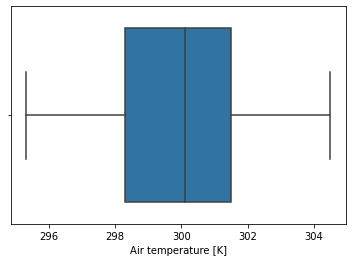

In [26]:
ax=sns.boxplot(x='Air temperature [K]',data=df)

#### Box and whisker plot for the  attribute "Process Temperature [K]"
After plotting the box and whisker plot for this attribute we get to know that there are no outliers for this attribute.

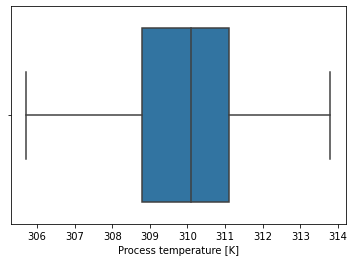

In [27]:
ax=sns.boxplot(x='Process temperature [K]',data=df)

#### Box and whisker plot for the  attribute "Rotation speed [rpm]"
After plotting the box and whisker plot for this attribute we get to know that there are outliers for this attribute so we have used the Data representation design pattern i.e Scaling(clipping) to overcome outliers.

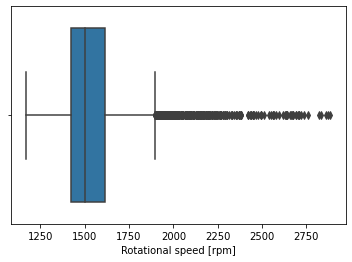

In [28]:
ax=sns.boxplot(x='Rotational speed [rpm]',data=df)

In [29]:
df['Rotational speed [rpm]'].describe()

count    10000.000000
mean      1538.776100
std        179.284096
min       1168.000000
25%       1423.000000
50%       1503.000000
75%       1612.000000
max       2886.000000
Name: Rotational speed [rpm], dtype: float64

### Clipping of the attribute values
We have clipped the values in the Inter Quartile Range.

In [30]:
df['Rotational speed [rpm]']=df['Rotational speed [rpm]'].clip(lower=1423.00,upper=1800)

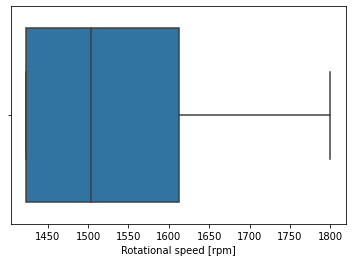

In [31]:
ax=sns.boxplot(x='Rotational speed [rpm]',data=df)

#### Box and whisker plot for the  attribute "Torque [Nm]"
After plotting the box and whisker plot for this attribute we get to know that there are outliers for this attribute so we have used the Data representation design pattern i.e Scaling(clipping) to overcome outliers.

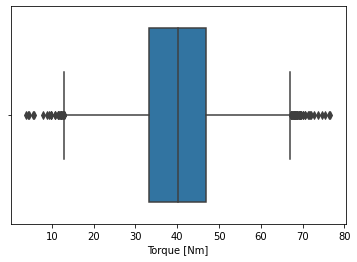

In [32]:
ax=sns.boxplot(x='Torque [Nm]',data=df)

In [33]:
df['Torque [Nm]'].describe()

count    10000.000000
mean        39.986910
std          9.968934
min          3.800000
25%         33.200000
50%         40.100000
75%         46.800000
max         76.600000
Name: Torque [Nm], dtype: float64

### Clipping of the attribute values
We have clipped the values in the Inter Quartile .

In [34]:
df['Torque [Nm]']=df['Torque [Nm]'].clip(lower=33.200,upper=46.80)

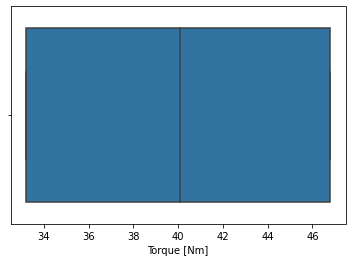

In [35]:
ax=sns.boxplot(x='Torque [Nm]',data=df)

#### Box and whisker plot for the  attribute "Tool wear [min]"
After plotting the box and whisker plot for this attribute we get to know that there are no outliers for this attribute.

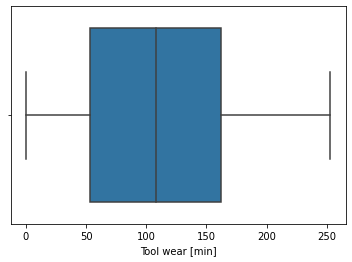

In [36]:
ax=sns.boxplot(x='Tool wear [min]',data=df)

## Support Vector Machine 
We have trained our model using SVM so that we can combine the results that we have obtained from a single classifier SVM,
and the results that we get after applying the ensemble design pattern.

### Robust Scaler
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.
Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

### Cross-fold validation
We have performed stratified sampling and cross-fold validation by making 5 splits of the data.

In [39]:
acc_svm_rbf=[]
kf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for fold , (trn_,val_) in enumerate(kf.split(X=df_resampled,y=y_res)):
    
    X_train=df_resampled.loc[trn_,feature_col]
    y_train=df_resampled.loc[trn_,target_col]
    
    X_valid=df_resampled.loc[val_,feature_col]
    y_valid=df_resampled.loc[val_,target_col]
    print('x_train shape is :'+str(X_train.shape))
    print('X_valid shape is :'+str(X_valid.shape))
    ro_scaler=RobustScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)
    
    clf=SVC(kernel="rbf")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))


x_train shape is :(46297, 8)
X_valid shape is :(11575, 8)
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1930
           1       0.97      0.85      0.91      1927
           2       0.99      1.00      0.99      1931
           3       0.99      1.00      0.99      1929
           4       0.94      0.96      0.95      1929
           5       0.93      1.00      0.96      1929

    accuracy                           0.97     11575
   macro avg       0.97      0.97      0.97     11575
weighted avg       0.97      0.97      0.97     11575

x_train shape is :(46297, 8)
X_valid shape is :(11575, 8)
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1930
           1       0.97      0.84      0.90      1927
           2       0.99      1.00      0.99      1930
           3       0.99      1.00      0.99      1929
           4       0.92      0.9

# Ensemble Design Pattern (Combining Classifiers)
## Random forest classifier
We have used Random forest classifier with 7 estimators

In [40]:
acc_RandF=[]
kf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for fold , (trn_,val_) in enumerate(kf.split(X=df_resampled,y=y_res)):
    
    X_train=df_resampled.loc[trn_,feature_col]
    y_train=df_resampled.loc[trn_,target_col]
    
    X_valid=df_resampled.loc[val_,feature_col]
    y_valid=df_resampled.loc[val_,target_col]
    ro_scaler=RobustScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)
    
    clf=RandomForestClassifier(n_estimators=7,criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1930
           1       1.00      0.97      0.98      1927
           2       0.99      1.00      1.00      1931
           3       1.00      1.00      1.00      1929
           4       0.99      1.00      1.00      1929
           5       0.99      1.00      0.99      1929

    accuracy                           0.99     11575
   macro avg       0.99      0.99      0.99     11575
weighted avg       0.99      0.99      0.99     11575

The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1930
           1       0.99      0.96      0.98      1927
           2       1.00      1.00      1.00      1930
           3       1.00      1.00      1.00      1929
           4       0.99      1.00      0.99      1930
           5       0.99      1.00      0.99      1929

    accuracy                           